# Evaluation of the Dense and Convolutional layer explanations

## Load RefAE and Classifier

In [1]:
import os, pathlib

file_path = os.path.dirname(os.path.realpath("__file__"))
home_dir = pathlib.Path(file_path).parent.parent
os.chdir(home_dir)

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from src.common import load_layer_activations, get_model_prediction, SAVED_PICS_PATH

from src.fashion_mnist.data import get_fashion_mnist_train_test, get_fashion_mnist_labels_categorical
from src.fashion_mnist.file_names import SAVED_CLASSIFIER_PATH, SAVED_CLADEC_PATH, SAVED_REFAE_PATH

SAVED_EVAL_PICS_PATH = SAVED_PICS_PATH.joinpath('fashion_mnist')

tf.random.set_seed(1234)
np.random.seed(1234)

In [3]:
# load the data
(dense_train_acts, dense_test_acts), (conv_train_acts, conv_test_acts) = load_layer_activations(SAVED_CLASSIFIER_PATH)
train_images, test_images = get_fashion_mnist_train_test()
train_labels_c, test_labels_c = get_fashion_mnist_labels_categorical()

# load RefAE model
refae_dense_path = SAVED_REFAE_PATH.joinpath('dense')
refae_conv_path = SAVED_REFAE_PATH.joinpath('conv')
refae_dense = keras.models.load_model(refae_dense_path)
refae_conv = keras.models.load_model(refae_conv_path)

2022-06-03 13:01:18.604425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 13:01:18.657580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 13:01:18.657910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 13:01:18.659577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
# load classifier and split classification into correct and wrong
# we save the indices for simplicity so we can get the corresponding layer activations
test_labels = np.argmax(test_labels_c, axis=1)
encoding = ["T-Shirt (Top)", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# only look at images with Sneakers
class_indices = np.where(test_labels == 7)
test_images = test_images[class_indices]
test_labels = test_labels[class_indices]
dense_test_acts = dense_test_acts[class_indices]
conv_test_acts = conv_test_acts[class_indices]

classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH)
classifier_test_out = np.argmax(classifier.predict(test_images), axis=1)
label_comparison = classifier_test_out == test_labels
correct_indices = label_comparison.nonzero()[0]
label_comparison = classifier_test_out != test_labels
wrong_indices = label_comparison.nonzero()[0]

2022-06-03 13:01:25.414636: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


32/32 [==============================] - 5s 5ms/step


## Apply ClaDec on random images from test dataset

In [5]:
# select some correctly and some misclassified images randomly

n_correct = 3
n_wrong = 5
n = n_correct + n_wrong
rand_indices_correct = np.random.choice(correct_indices, n_correct, replace=False)
rand_indices_wrong = np.random.choice(wrong_indices, n_wrong, replace=False)
rand_indices = np.concatenate((rand_indices_correct, rand_indices_wrong))
classes_correct = test_labels[rand_indices]
classes_classified = classifier_test_out[rand_indices]

# get corresponding activations
eval_images = test_images[rand_indices]
eval_dense_acts = dense_test_acts[rand_indices]
eval_conv_acts = conv_test_acts[rand_indices]

# get reference reconstructions
eval_refae_dense = refae_dense.predict(eval_images)
eval_refae_conv = refae_conv.predict(eval_images)

1/1 [==============================] - 0s 157ms/step


In [6]:
# get ClaDec reconstructions for all models saved in `saved-models` directory
alphas = [0, 1, 50, 99]
cladec_eval_data_dense = []
cladec_eval_data_conv = []

for alpha in alphas:
    cladec_path = SAVED_CLADEC_PATH.joinpath(f'{alpha:2}')
    cladec_dense_path = cladec_path.joinpath("dense")
    cladec_conv_path = cladec_path.joinpath("conv")
    cladec_eval_data_dense.append(get_model_prediction(cladec_dense_path, eval_dense_acts))
    cladec_eval_data_conv.append(get_model_prediction(cladec_conv_path, eval_conv_acts))

1/1 [==============================] - 0s 72ms/step


## Show explanations of ClaDec for different `alpha` values.

### explaining the dense layer

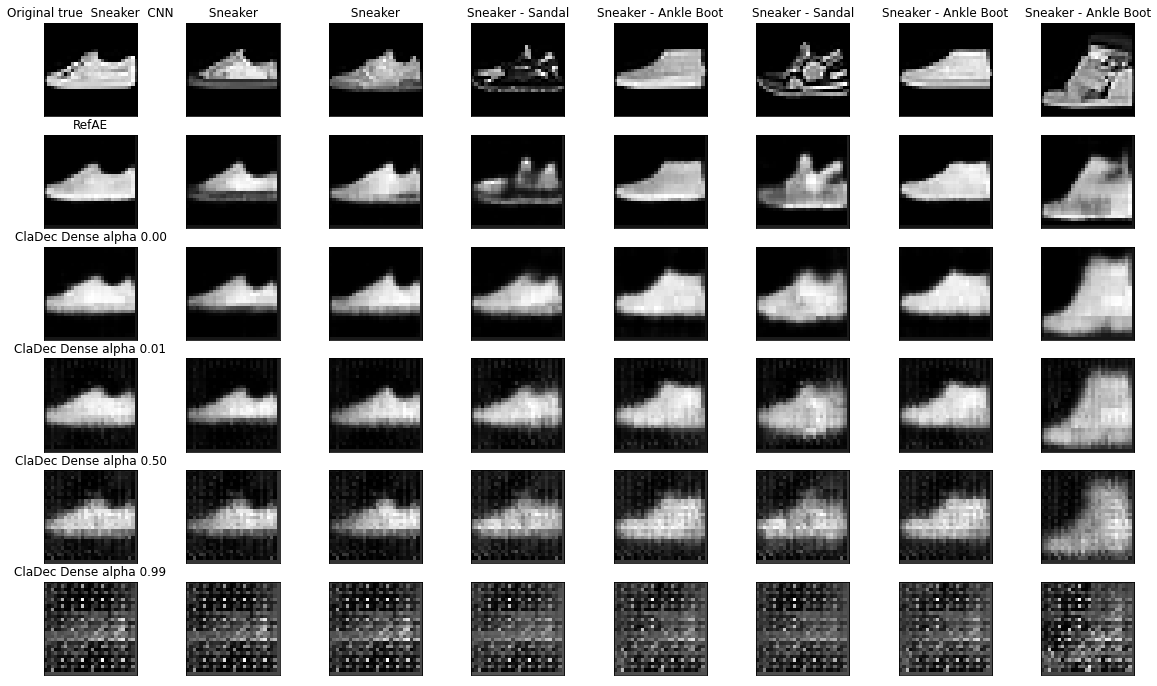

In [8]:
num_rows = 2 + len(alphas)
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)
    if classes_correct[i] == classes_classified[i]:
        title = f' {encoding[classes_correct[i]]} '
    else:
        title = f'{encoding[classes_correct[i]]} - {encoding[classes_classified[i]]}'
    if x == 1:
        ax.set_title("Original true " + title + " CNN")
    else:
        ax.set_title(title)

    plt.imshow(eval_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(eval_refae_dense[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display cladec
    j = 2
    for alpha, data in zip(alphas, cladec_eval_data_dense):
        ax = plt.subplot(num_rows, n, x + j * n)
        j += 1
        if x == 1:
            ax.set_title(f'ClaDec Dense alpha {alpha / 100:0.2f}')
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.savefig(SAVED_EVAL_PICS_PATH.joinpath('sneaker_dense.png'))
plt.show()

### explaining the conv layer

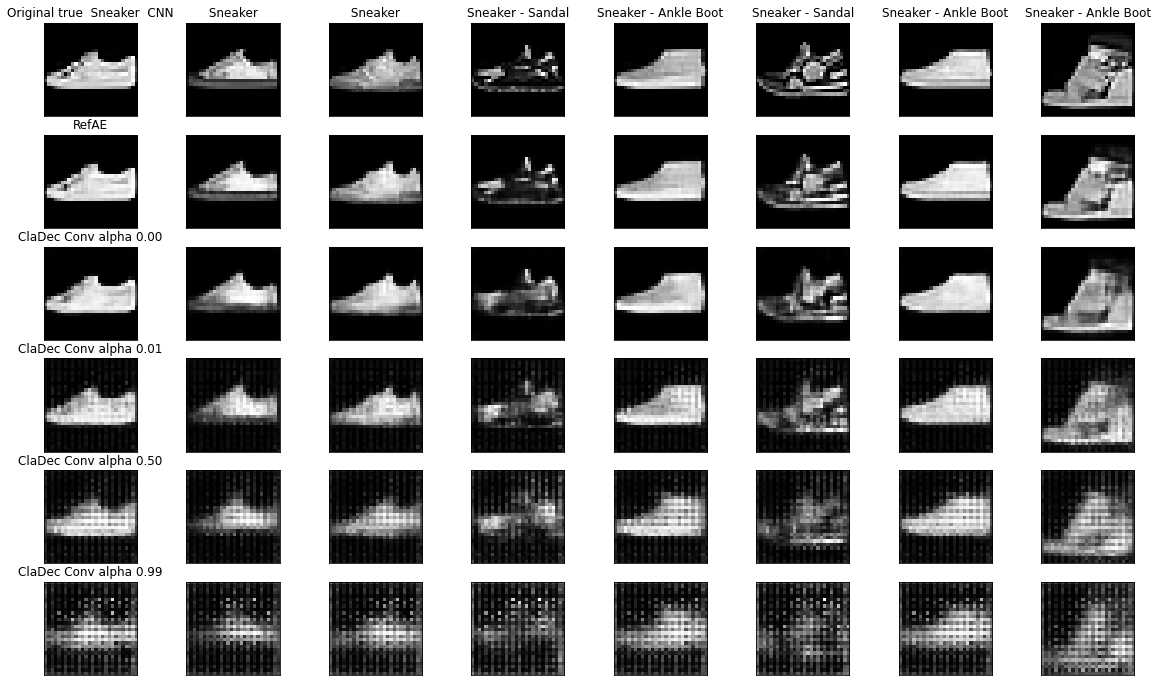

In [9]:
num_rows = 2 + len(alphas)
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)
    if classes_correct[i] == classes_classified[i]:
        title = f' {encoding[classes_correct[i]]} '
    else:
        title = f'{encoding[classes_correct[i]]} - {encoding[classes_classified[i]]}'
    if x == 1:
        ax.set_title("Original true " + title + " CNN")
    else:
        ax.set_title(title)

    plt.imshow(eval_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(eval_refae_conv[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display cladec
    j = 2
    for alpha, data in zip(alphas, cladec_eval_data_conv):
        ax = plt.subplot(num_rows, n, x + j * n)
        j += 1
        if x == 1:
            ax.set_title(f'ClaDec Conv alpha {alpha / 100:0.2f}')
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.savefig(SAVED_EVAL_PICS_PATH.joinpath('sneaker_conv.png'))
plt.show()